# Equal-sized Bins Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of bins to use.
NUMBER_OF_BINS = 5

In [2]:
import numpy as np
from utils.data_handler import load_splats

from utils.constants import IMAGE_HEIGHT, IMAGE_WIDTH

In [3]:
splats = load_splats(DATA_NAME)

# Cluster Splats
- Create N bins from the minimum non-zero depth to the maximum depth.
- For each pixel, collect splats into bins based on their depth.
- In each bin, sum the premultiplied colors and sum the alphas.

In [4]:
# Compute the minimum and maximum depth of the image.
depth_values = splats[:, :, 1]
depth_values = depth_values[depth_values > 0]
min_depth = np.min(depth_values)
max_depth = np.max(depth_values)

print(f"Min depth: {min_depth}, Max depth: {max_depth}")
print(f"Each bin will be {(max_depth - min_depth) / NUMBER_OF_BINS} units wide.")

Min depth: 1.2029399871826172, Max depth: 11.86460018157959
Each bin will be 2.1323320865631104 units wide.


In [5]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [6]:
def collect_splats(pixel_splats, number_of_bins, min_bin_depth, max_bin_depth):
    """Cluster splats into bins based on their depth."""
    
    # Initialize clustering 2D list: cluster -> [[alpha, *color], ...].
    pixel_clustering = [[] for _ in range(number_of_bins)]

    # Loop through each splat.
    for splat in pixel_splats:
        # Skip transparent splats.
        if splat[0] == 0:
            continue

        # Compute the bin index.
        bin_index = int((splat[1] - min_bin_depth) / (max_bin_depth - min_bin_depth) * (number_of_bins - 1))
        
        # Add the splat to the bin.
        pixel_clustering[bin_index].append(np.concatenate(([splat[0]], splat[2:])))

    # Commutative combination of the splats in each cluster (alpha, color).
    pixel_output = np.zeros((len(pixel_clustering), 4))
    for index, cluster in enumerate(pixel_clustering):
        if not cluster:
            continue
        cluster = np.array(cluster)
        pixel_output[index, 0] = 1 - np.prod(1 - cluster[:, 0])
        alpha_sum = np.sum(cluster[:, 0])
        if alpha_sum:
            pixel_output[index, 1:] = np.sum(cluster[:, 0].reshape(-1, 1) * cluster[:, 1:], axis=0) / alpha_sum
        else:
            pixel_output[index, 1:] = np.zeros(3)

    # Return computation.
    return pixel_output

## Do the Clustering
1. Sorted splats straight from the CSV file.
2. Shuffled splats in each pixel.

In [7]:
# Cluster the splats (sorted).
clustered_splats = Parallel(n_jobs=-1)(
    delayed(collect_splats)(pixel_splats, NUMBER_OF_BINS, min_depth, max_depth) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

/Users/kenneth/Documents/School_GitHub/PLSE/clustering-exploration/venv/clustering-exploration/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid = os.fork()


In [8]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

# Cluster shuffled splats.
cluster_shuffled_splats = Parallel(n_jobs=-1)(
    delayed(collect_splats)(pixel_splats, NUMBER_OF_BINS, min_depth, max_depth) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Bins
- Compute the color of each pixel using the clustered splats.
- Use the alpha-over blending formula with each bin from front to back.
- The color of each bin is the sum of the premultiplied colors divided by the sum of alphas.

In [9]:
def alpha_over_pixel(pixel_clusters):
    """Compute the color of each pixel using the clustered splats."""
    # Define the transmittance and pixel color for the first bin.
    transmittance = 1.0
    pixel_color = np.zeros(3)

    # Loop through remaining bins.
    for cluster_alpha, *cluster_color in pixel_clusters:
        # Skip transparent bin.
        if not cluster_alpha:
            continue
        # Exit once the transmittance is basically zero.
        if transmittance <= 0.001:
            break

        # Compute the pixel color.
        pixel_color += cluster_alpha * np.array(cluster_color) * transmittance

        # Compute the transmittance.
        transmittance *= 1 - min(1, cluster_alpha)

    # Return the computed pixel color.
    return pixel_color

## Do the Computation

In [10]:
# Sorted image.
computed_image = [alpha_over_pixel(pixel_clusters) for pixel_clusters in tqdm(clustered_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [11]:
# Shuffled image.
computed_shuffled_image = [alpha_over_pixel(pixel_clusters) for pixel_clusters in tqdm(cluster_shuffled_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the Results


In [12]:
from utils.image_handler import save_array_to_image

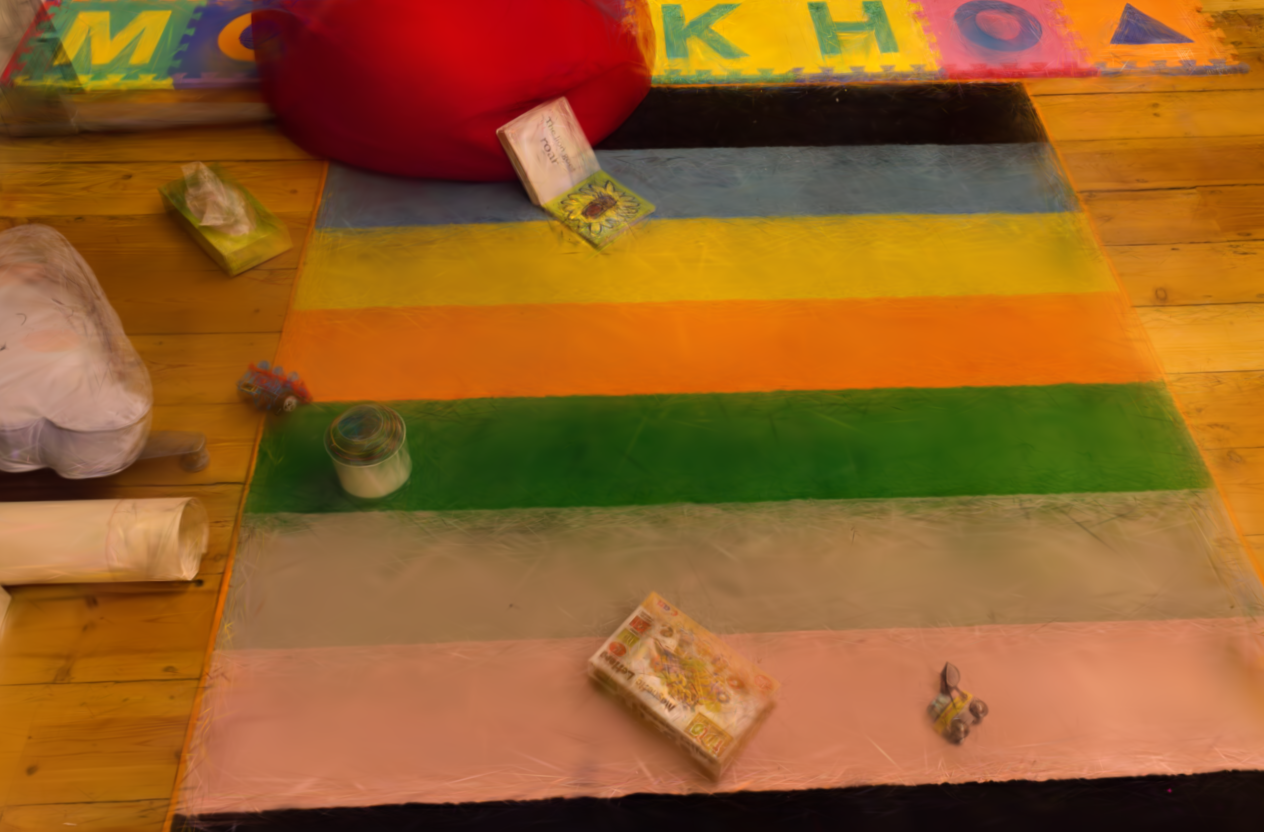

In [14]:
# Display the sorted image.
display(save_array_to_image(np.array(computed_image).reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3)), "binned_clustering_sorted"))

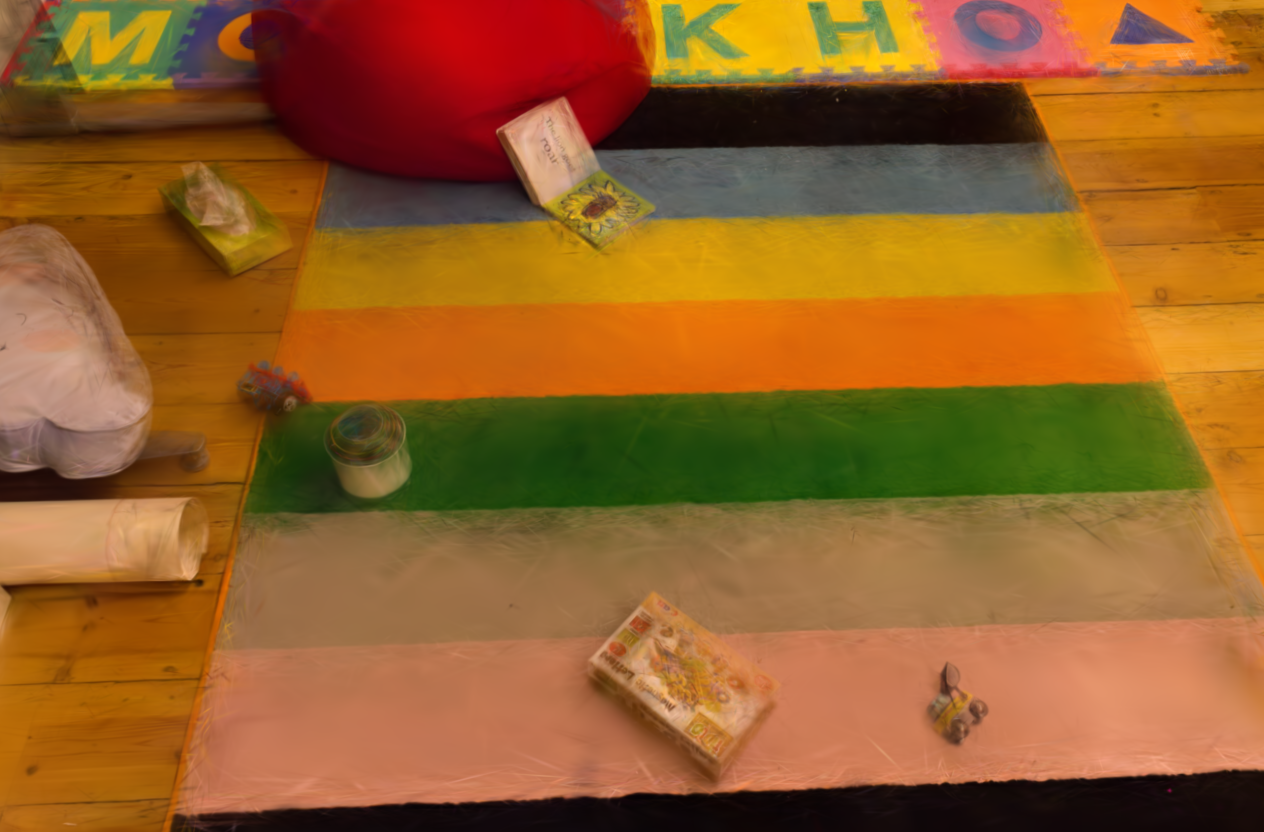

In [15]:
# Display the shuffled image.
display(save_array_to_image(np.array(computed_shuffled_image).reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3)), "binned_clustering"))